### Generate linear array (e.g., DAS array) CCF waveforms through PYGRT based on a 1D layered model
### Created by Yusong Yuan on 12/24/2025### The calculation of the cross-correlation function in the current code needs to be updated to a frequency-domain algorithm, and a cross-correlation window parameter should be added.The calculation of the cross-correlation function in the current code needs to be updated to a frequency-domain algorithm, and a cross-correlation window parameter should be added.


In [ ]:
import numpy as np
import pygrt
import os
from obspy import read 
import matplotlib.pyplot as plt
import numpy as np 
import re

In [2]:
# generate waveforms

sac_directory = './SAC/'
for filename in os.listdir(sac_directory):
    file_path = os.path.join(sac_directory, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

modarr = np.loadtxt("model/mean_model_layer.txt", delimiter=',', skiprows=0)

pymod = pygrt.PyModel1D(modarr, 0.06, 0.06)

dist_arr = np.arange(3., 5.01, 0.02)
stgrns = pymod.compute_grn(distarr=dist_arr, nt=800, dt=0.04,upsampling_n=1, freqband=[0.3,5.], print_runtime=False,calc_upar=True)

ricker = pygrt.sigs.gen_ricker_wave(f0=1., dt=0.04)

for i in range(len(dist_arr)):
    dist = dist_arr[i]
    stgrn = stgrns[i]
    st = pygrt.utils.gen_syn_from_gf_SF(stgrn, S=1e16, fN=5, fE=0, fZ=0, az=0, calc_upar=True)
    st_strain = pygrt.utils.compute_strain(st)
    st_strain = pygrt.utils.stream_convolve(st_strain, ricker)

    # tr_Z = st_strain.select(channel="*Z")[0]
    # tr_Z.stats.station = str(i+1)
    # tr_Z.stats.dist = dist

    tr_R = st_strain.select(channel="*RR")[0]
    tr_R.stats.station = str(i+1)
    tr_R.stats.dist = dist

    # tr_Z.write(f"SAC/Station_{i+1}.Z", format="SAC")
    tr_R.write(f"SAC/Station_{i+1}.R", format="SAC")

Length=31.72


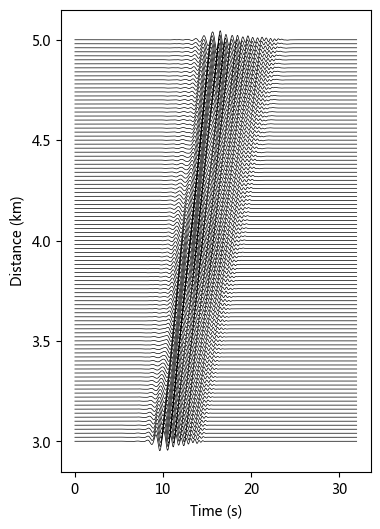

In [3]:
# plot waveforms

def tapering_wf(tr,tmin,tmax):
    '''
    subroutine for tapering utilizing obspy
    
    tr - obspy trace object
    taxis - time axis of the input trace
    tmin,tmax - the start and end of the tapering window
    '''
    npts = tr.stats.sac.npts; delta = tr.stats.delta
    t0 = tr.stats.sac.b
    taxis = np.linspace(t0,t0+npts*delta-delta,npts)
    ind_taper = (taxis >= tmin) & (taxis <= tmax)
    
    tr_copy = tr.copy()
    tr_copy.data = tr.data[ind_taper]
    tr_copy.taper(max_percentage=0.05)
    
    data = np.zeros_like(tr.data)
    data[ind_taper] = tr_copy.data
    tr_copy.data = data
    return tr_copy

st = read("SAC/*.R")
st.filter('bandpass',freqmin=0.3,freqmax=5,zerophase=True)
nt = st[0].stats.npts
dt = st[0].stats.delta

scale = 0.05
t = np.arange(0, nt)*dt
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
for tr in st:
    dist = tr.stats.sac.dist
    tr.taper(max_percentage=0.05)
    tr = tapering_wf(tr, dist/3., dist/0.2)
    data = tr.data.copy()
    data /= np.max(np.abs(data))

    
    ax.plot(t,data*scale+dist, 'k', lw=0.5) 

ax.set_ylabel("Distance (km)")
ax.set_xlabel("Time (s)")
plt.show()

In [4]:
# calculate CCFs

sac_directory = './CCF'
for filename in os.listdir(sac_directory):
    file_path = os.path.join(sac_directory, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

stas = np.array([int(re.match(r"Station_(\d+)", f).group(1))
                            for f in os.listdir('./SAC') if re.match(r"Station_\d+\.(R)", f)])
stas.sort()
#stas=np.array([1])
for src in stas:
    tr0_R = read(f"SAC/Station_{src}.R")[0]
    dist = tr0_R.stats.sac.dist
    #tr0_Z = read(f"SAC/Station_{src}.Z")[0]
    tr0_R = tapering_wf(tr0_R, dist/3., dist/0.1)

    for sta in stas:
        if sta < src+5:
            continue

        tr_R = read(f"SAC/Station_{sta}.R")[0]
        dist = tr_R.stats.sac.dist
        tr_R = tapering_wf(tr_R, dist/3., dist/0.1)
        #tr_Z = read(f"SAC/Station_{sta}.Z")[0]

        #corr_Z = np.correlate(tr_Z.data, tr0_Z.data, mode='full')
        corr_R = np.correlate(tr_R.data, tr0_R.data, mode='full')

        # tr_Z_cc = tr_Z.copy()
        tr_R_cc = tr_R.copy()

        # tr_Z_cc.data = corr_Z
        tr_R_cc.data = corr_R

        # tr_Z_cc.stats.sac.b = -(len(corr_Z) - 1) / 2 * tr_Z_cc.stats.delta
        tr_R_cc.stats.sac.b = -(len(corr_R) - 1) / 2 * tr_R_cc.stats.delta

        # tr_Z_cc.stats.sac.dist = tr_Z.stats.sac.dist - tr0_Z.stats.sac.dist
        tr_R_cc.stats.sac.dist = tr_R.stats.sac.dist - tr0_R.stats.sac.dist
        
        # tr_Z_cc.stats.npts = len(corr_Z)
        tr_R_cc.stats.npts = len(corr_R)
        # tr_Z_cc.write(f"CCF/{src}-{sta}_CC.Z", format="SAC")
        tr_R_cc.write(f"CCF/{src}-{sta}_CC.R", format="SAC")

        # corr_ZR = np.correlate(tr_R.data, tr0_Z.data, mode='full')
        # tr_ZR_cc = tr_Z.copy()
        # tr_ZR_cc.data = corr_ZR
        # tr_ZR_cc.stats.sac.b = -(len(corr_ZR) - 1) / 2 * tr_ZR_cc.stats.delta  # 以采样间隔为单位
        # tr_ZR_cc.stats.sac.dist = tr_Z.stats.sac.dist - tr0_Z.stats.sac.dist 
        # tr_ZR_cc.stats.npts = len(corr_ZR)

        # tr_ZR_cc.write(f"CCF/{src}-{sta}_CC.ZR", format="SAC")


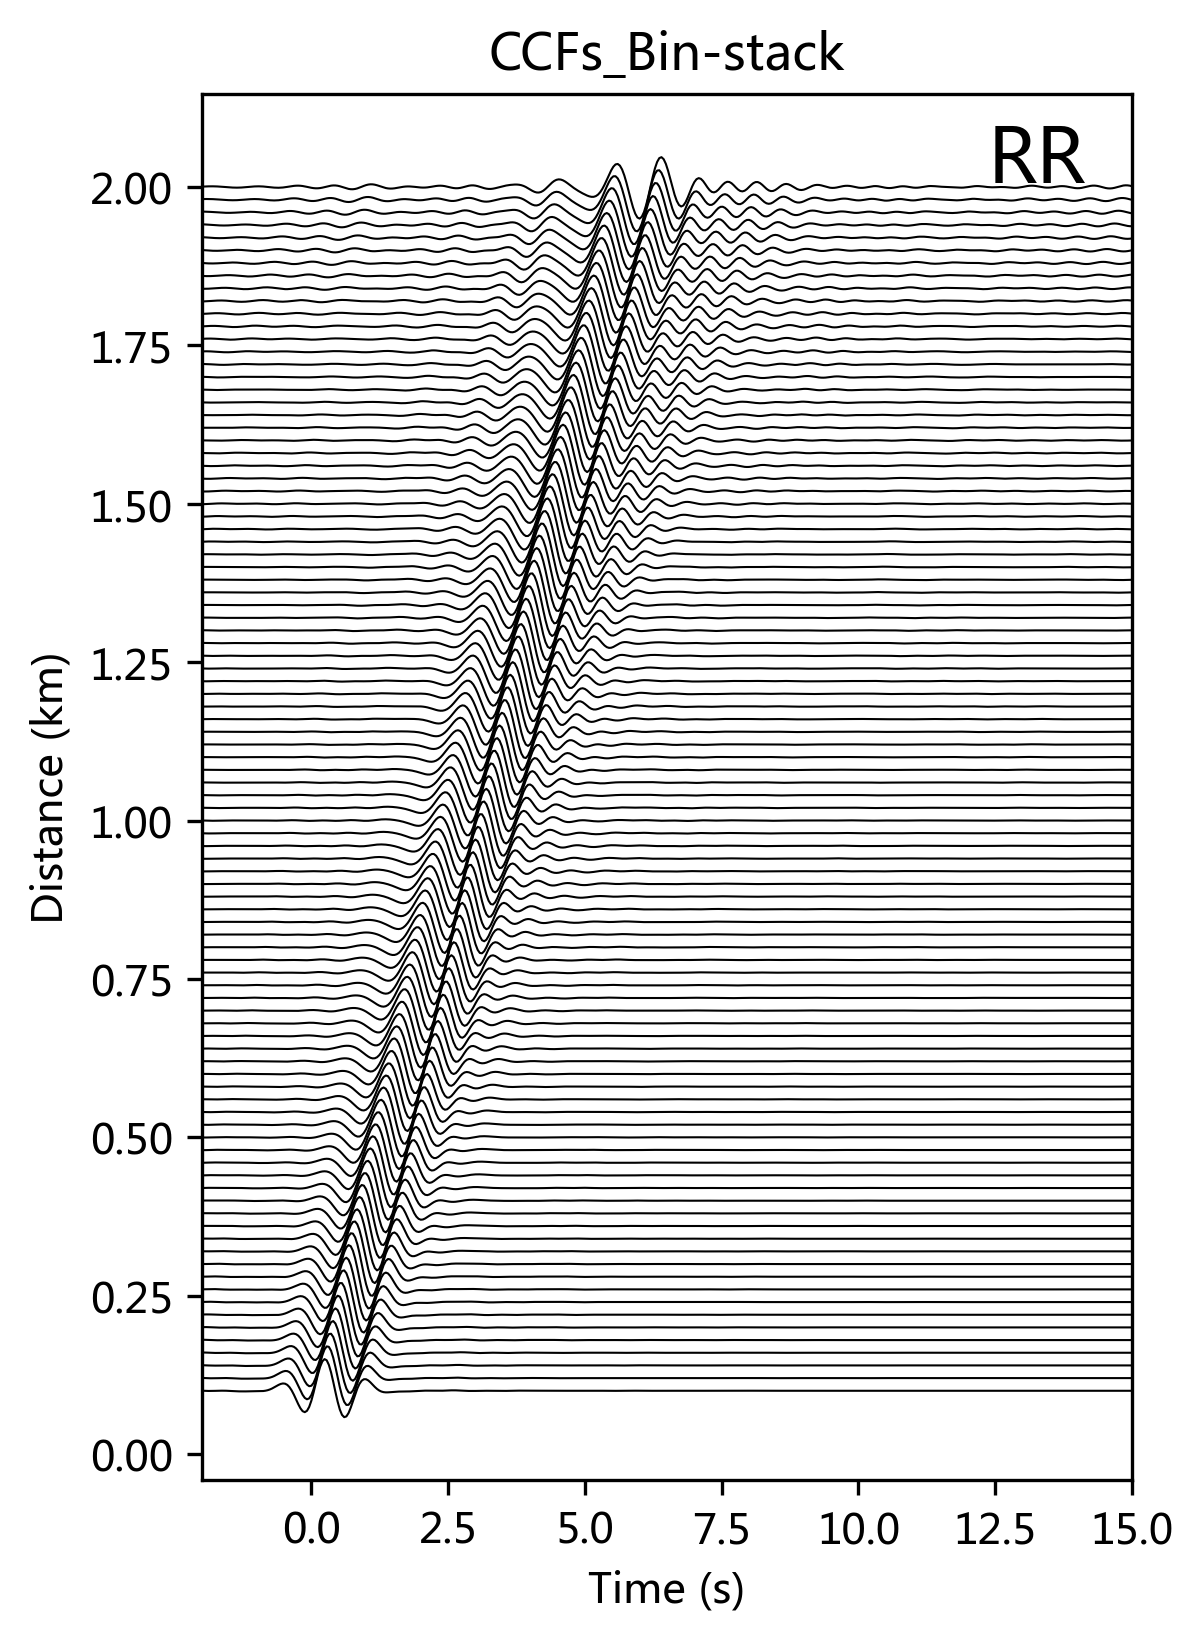

In [5]:
# plot CCFs

st = read("CCF/*.R")
st.filter('bandpass',freqmin=0.5,freqmax=3.5,zerophase=True)
nt = st[0].stats.npts
dt = st[0].stats.delta
t0 = -(nt- 1) / 2 * dt
scale = 0.05
t = np.linspace(t0,t0+nt*dt-dt,nt)
fig, ax = plt.subplots(1, 1, figsize=(4, 6),dpi=300)

dist_groups = {}
for tr in st:
    dist = tr.stats.sac.dist
    data = tr.copy().data
    data -= np.mean(data)
    #data /= np.max(np.abs(data))

    # 分组并叠加
    for key in dist_groups:
        if abs(dist - key) < 0.01:
            dist_groups[key] += data
            break
    else:
        dist_groups[dist] = data

# 绘制叠加结果
for dist, data_stack in dist_groups.items():
    ax.plot(t, data_stack/np.max(np.abs(data_stack)) * scale + dist, 'k', lw=0.5)

ax.text(0.95, 0.98, 'RR', transform=ax.transAxes, ha='right', va='top', fontsize=18, color='black')
ax.set_title("CCFs_Bin-stack")
ax.set_ylabel("Distance (km)")
ax.set_xlabel("Time (s)")
# ax.set_ylim([0.9, 3.1])
ax.set_xlim([-2, 15])

plt.show()